## Project 6 - Dustin Berry

### DSCI 614

### 1. Load the dataset of sentiment140.csv into memory.

In [1]:
import re
import spacy
import string
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import scattertext as st
import matplotlib.pyplot as plt

from time import time
from pprint import pprint
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import TfidfVectorizer

warnings.filterwarnings("ignore")

#I tried tried to install a package to use all of my CPU cores and it messed up my system's encoding.
#That's the reason for the encoding part below.  I'll probably have to uninstall and reinstall python from what I can tell.
#Without switching the encoding the file won't read in.
tweets=pd.read_csv('C:\\Users\\dusti\\Documents\\Maryville\\Text Mining\\sentiment140.csv', header=None, encoding='latin1')

tweets.head(5)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


### 2. Clean and preprocess the texts.

In [2]:
#reduce down to only the polarity and the text of the tweet
tweets = tweets[[0,5]]
tweets = tweets.rename(columns = {0:'polarity', 5:'text'}, inplace=False)

tweets.head(5)

,polarity,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [3]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   text      1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [4]:
tweets.polarity = tweets.polarity.map({ 0 : 'negative', 4 : 'positive'})

tweets.head(5)

,polarity,text
0,negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,negative,is upset that he can't update his Facebook by ...
2,negative,@Kenichan I dived many times for the ball. Man...
3,negative,my whole body feels itchy and like its on fire
4,negative,"@nationwideclass no, it's not behaving at all...."


In [5]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  object
 1   text      1600000 non-null  object
dtypes: object(2)
memory usage: 24.4+ MB


In [6]:
#check the percentage of the sentiment
tweets['polarity'].value_counts(normalize= True)

negative    0.5
positive    0.5
Name: polarity, dtype: float64

In [7]:
#reduce to 0.1% of the original datatframe
tweets=tweets.sample(16000)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 1148248 to 1281519
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   polarity  16000 non-null  object
 1   text      16000 non-null  object
dtypes: object(2)
memory usage: 375.0+ KB


In [8]:
#check the percentage of the sentiment
tweets['polarity'].value_counts(normalize= True)

negative    0.5035
positive    0.4965
Name: polarity, dtype: float64

In [9]:
nlp = spacy.load("en_core_web_sm")
stop_words = spacy.lang.en.stop_words.STOP_WORDS

t0=time()

#create tokenzer function from a given sentence/review
def clean_text(sentence):
    # Remove nan, @airline, punctuation, URL, or any non alpanumeric characters and seperate word using a single space.
    sentence = ' '.join(re.sub("(nan)|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",sentence).split())
    # Removing stop words and obtain the lemma
    text = [ word.lemma_ for word in nlp(sentence) if word not in stop_words]
    return ' '.join(text).strip().lower()

#apply clean_text function
tweets['text_cleaned'] = tweets['text'].apply(clean_text)

print(f"It takes about {time() - t0:.1f} seconds")

It takes about 116.6 seconds


In [10]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 1148248 to 1281519
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   polarity      16000 non-null  object
 1   text          16000 non-null  object
 2   text_cleaned  16000 non-null  object
dtypes: object(3)
memory usage: 500.0+ KB


In [11]:
#check for missing data
percent_missing = tweets.isnull().sum() * 100 / len(tweets)
percent_missing

polarity        0.0
text            0.0
text_cleaned    0.0
dtype: float64

In [12]:
tweets.head(5)

,polarity,text,text_cleaned
1148248,positive,"How 2 get 1000 new followers daily, $1000 dail...",how 2 get 1000 new follower daily 1000 daily p...
66339,negative,is at home.... ready to go back to school,be at home ready to go back to school
1521199,positive,@Suw thank God somebody else does that.....cur...,thank god somebody else do that cursor thingy
1425288,positive,has just had an amazing day/night. Thanks ever...,have just have an amazing day night thanks eve...
664909,negative,No i couldn't find a date!!! lol.,no i couldn t find a date lol


### 3. Graphically summarize the polarity of the tweet.

<AxesSubplot:>

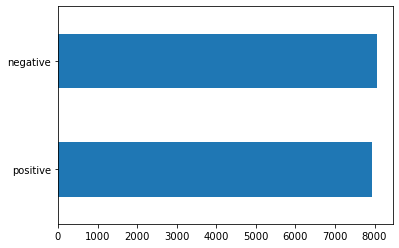

In [13]:
tweets.polarity.value_counts().sort_values().plot(kind = 'barh')

### 4. Graphically summarize the length of the text of the tweet using.
+ boxplot
+ histogram
+ density plot

In [14]:
tweets["len_text_bc"] = tweets["text"].str.len()
tweets["len_text_ac"] = tweets["text_cleaned"].str.len()

pd.options.display.float_format = "{:.2f}".format
tweets[["len_text_bc", "len_text_ac"]].describe()

,len_text_bc,len_text_ac
count,16000.00,16000.00
mean,73.98,60.94
std,36.51,33.37
min,7.00,0.00
25%,44.00,33.00
50%,69.00,57.00
75%,103.00,87.00
max,278.00,143.00


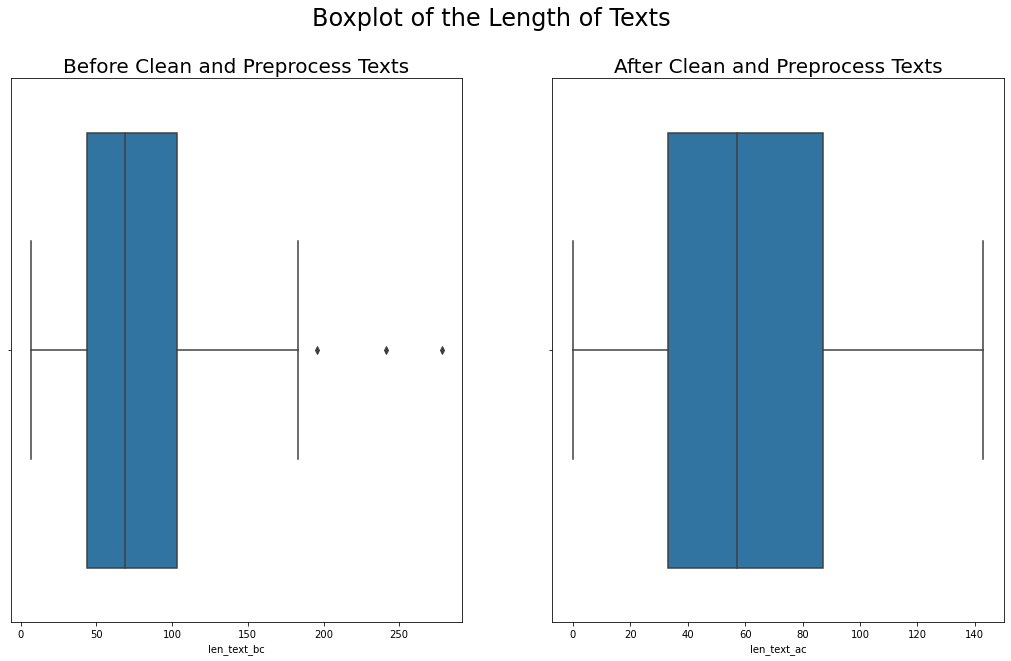

In [15]:
fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Boxplot of the Length of Texts', fontsize= 24)

#plot before cleaned
sns.boxplot(ax=axes[0], x=tweets['len_text_bc'])
axes[0].set_title('Before Clean and Preprocess Texts', fontsize= 20)
#plot after cleaning
sns.boxplot(ax=axes[1], x=tweets["len_text_ac"])
x=axes[1].set_title('After Clean and Preprocess Texts', fontsize= 20)

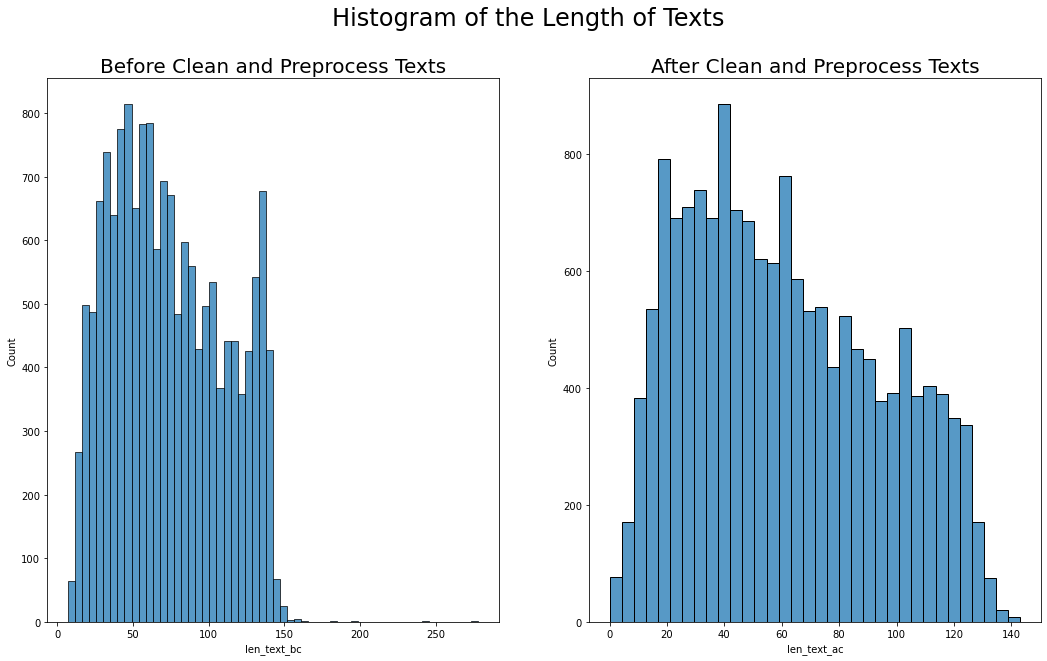

In [16]:
fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Histogram of the Length of Texts', fontsize= 24)

#plot before cleaned
sns.histplot(ax=axes[0], data = tweets, x='len_text_bc')
axes[0].set_title('Before Clean and Preprocess Texts', fontsize= 20)
#plot after cleaning
sns.histplot(ax=axes[1], data = tweets, x="len_text_ac")
x=axes[1].set_title('After Clean and Preprocess Texts', fontsize= 20)

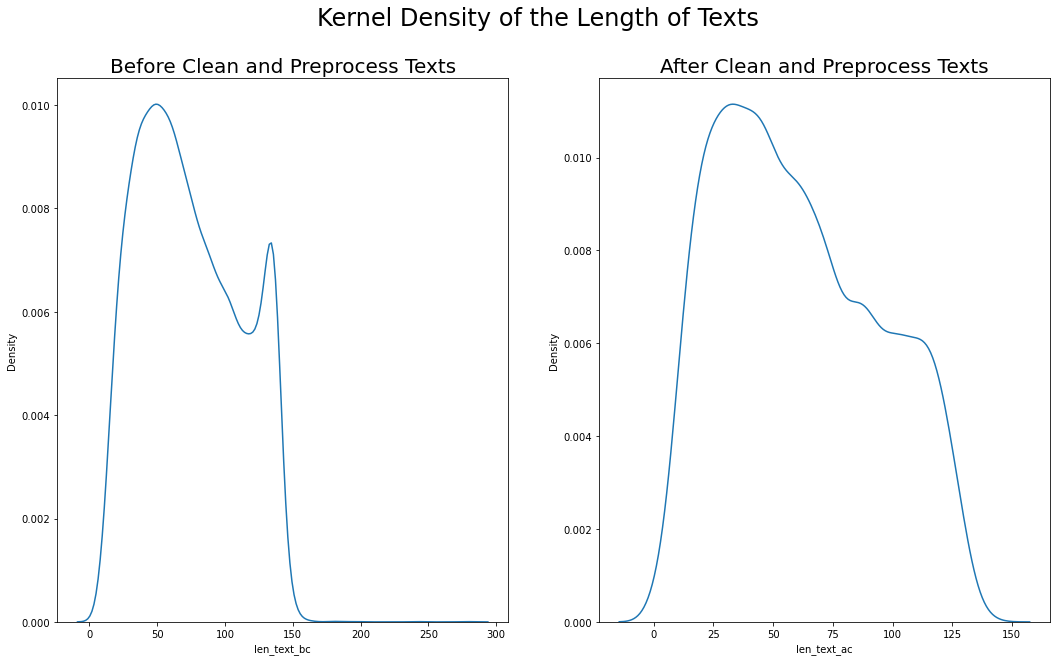

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Kernel Density of the Length of Texts', fontsize= 24)

#plot before cleaned
sns.kdeplot(ax=axes[0], data = tweets, x='len_text_bc')
axes[0].set_title('Before Clean and Preprocess Texts', fontsize= 20)

#plot after cleaning
sns.kdeplot(ax=axes[1], data = tweets, x='len_text_ac')
x=axes[1].set_title('After Clean and Preprocess Texts', fontsize= 20)

### 5. Graphically summarize the word count of the text of the tweet using
+ boxplot
+ histogram
+ density plot

In [18]:
tweets['count_word_bc'] = tweets['text'].str.split().str.len()
tweets['count_word_ac'] = tweets['text_cleaned'].str.split().str.len()

pd.options.display.float_format = "{:.2f}".format
tweets[['count_word_bc', 'count_word_ac']].describe()

,count_word_bc,count_word_ac
count,16000.00,16000.00
mean,13.16,13.29
std,6.94,7.34
min,1.00,0.00
25%,7.00,7.00
50%,12.00,12.00
75%,18.00,19.00
max,33.00,47.00


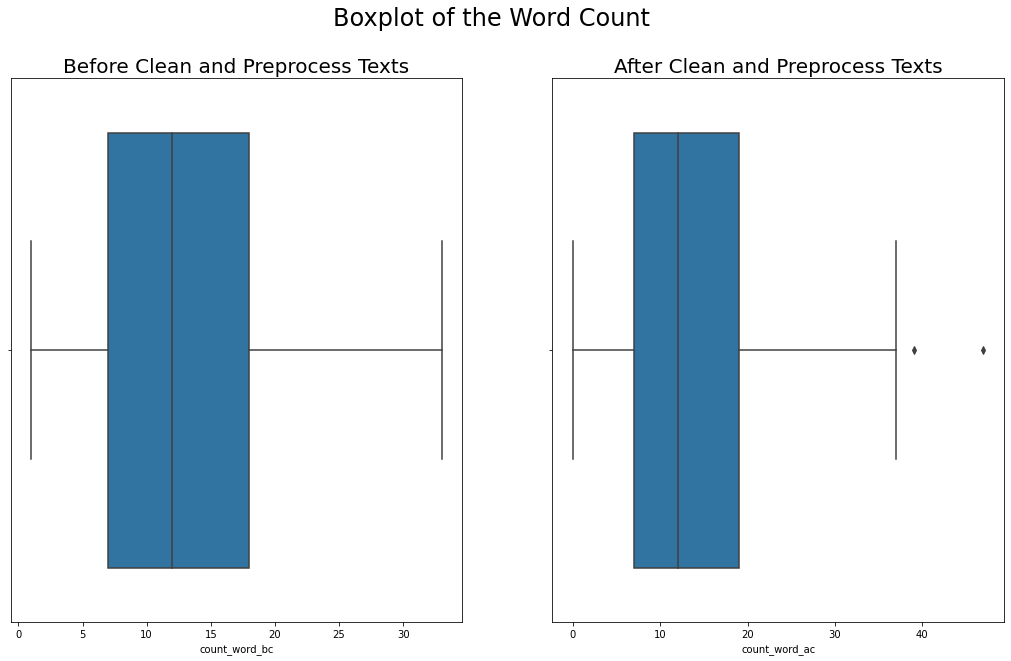

In [19]:
fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Boxplot of the Word Count', fontsize= 24)

sns.boxplot(ax=axes[0], x=tweets['count_word_bc'])
axes[0].set_title('Before Clean and Preprocess Texts', fontsize= 20)

sns.boxplot(ax=axes[1], x=tweets['count_word_ac'])
x=axes[1].set_title('After Clean and Preprocess Texts', fontsize= 20)

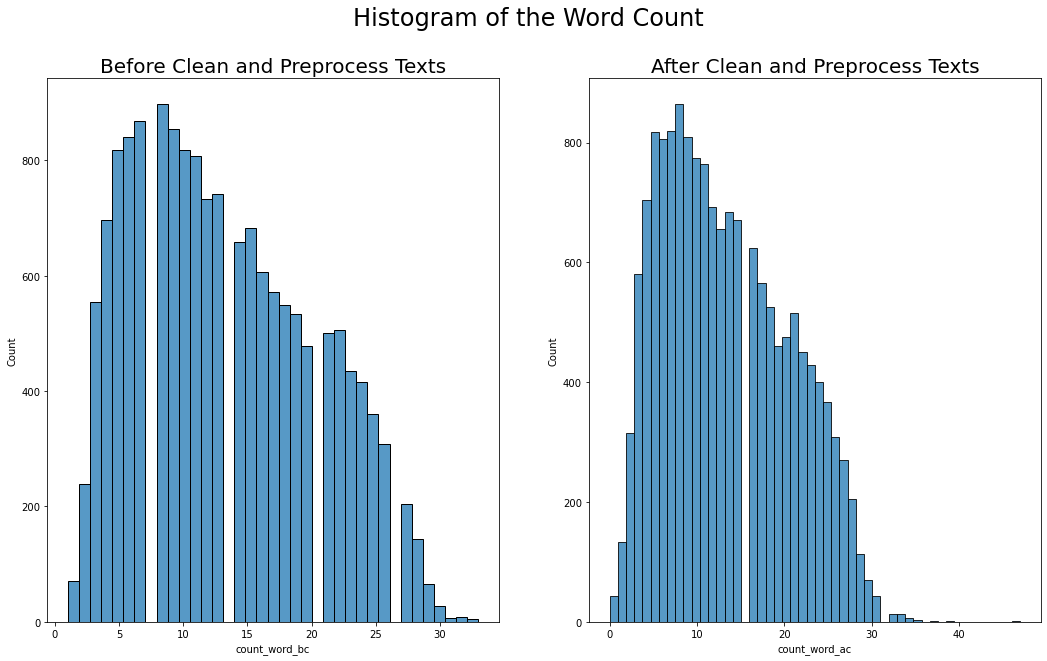

In [20]:
fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Histogram of the Word Count', fontsize= 24)

sns.histplot(ax=axes[0], data = tweets, x='count_word_bc')
axes[0].set_title('Before Clean and Preprocess Texts', fontsize= 20)

sns.histplot(ax=axes[1], data = tweets, x='count_word_ac')
x=axes[1].set_title('After Clean and Preprocess Texts', fontsize= 20)

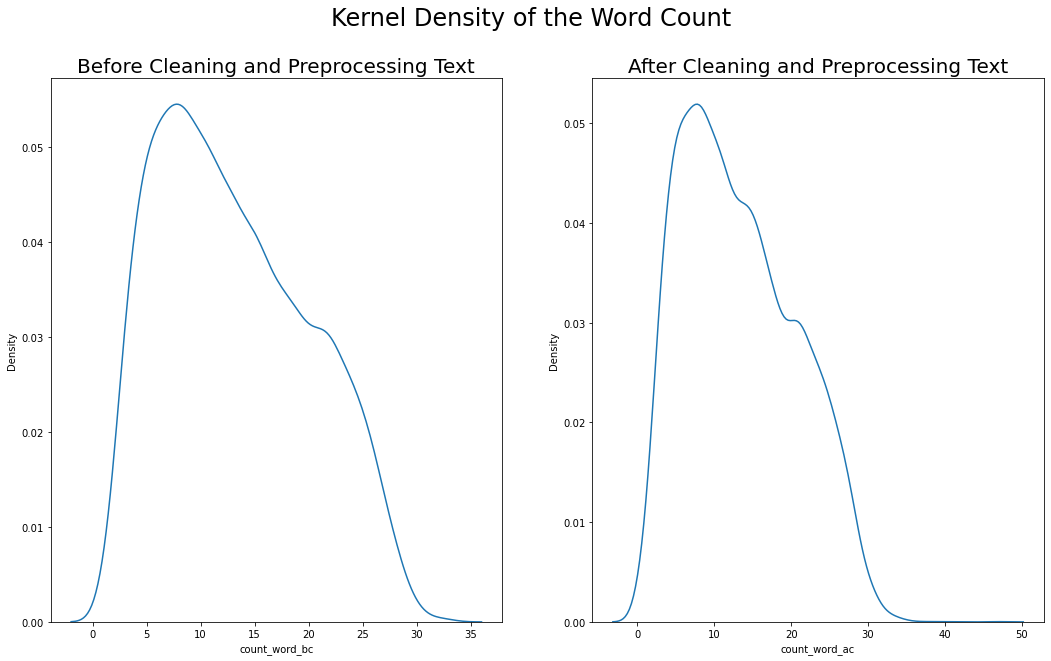

In [21]:
fig, axes = plt.subplots(1, 2, figsize = (17.8, 10))
fig.suptitle('Kernel Density of the Word Count', fontsize= 24)

sns.kdeplot(ax=axes[0], data = tweets, x='count_word_bc')
axes[0].set_title('Before Cleaning and Preprocessing Text', fontsize= 20)

sns.kdeplot(ax=axes[1], data = tweets, x='count_word_ac')
x=axes[1].set_title('After Cleaning and Preprocessing Text', fontsize= 20)

### 6. Graphically summarize the top 10 bigrams (2-gram) of the tf-idf of the text of the tweet.

In [22]:
#function for top words
def get_top_tf_idf_words(df=tweets, col='text', use_idf=True, ngram_range =(1,2), top_n=5):
    
    tf_idf = TfidfVectorizer(stop_words='english', ngram_range = ngram_range, use_idf = use_idf)
    #fit and transform the corpus
    X_sparse_matrix = tf_idf.fit_transform(df[col])
    feature_names = np.array(tf_idf.get_feature_names())
    #generate the tf-idf matrix
    tf_idf_sparse_matrix = tf_idf.transform(df[col])
    #rank the matrix by tf-idf values and return the indices of the top_n values
    sorted_idx = np.argsort(tf_idf_sparse_matrix.data)[:-(top_n+1):-1]
    
    #return the feature names and corresponding tf_idf values in a df
    return pd.DataFrame(
    {'feature': feature_names[tf_idf_sparse_matrix.indices[sorted_idx]],
     'tf_idf': tf_idf_sparse_matrix.data[sorted_idx],
    })

top_n = 10

#generate top tf-idf words
df_text_bc = get_top_tf_idf_words(df = tweets, col = 'text', top_n=top_n)
df_text_ac = get_top_tf_idf_words(df = tweets, col = 'text_cleaned', top_n=top_n)

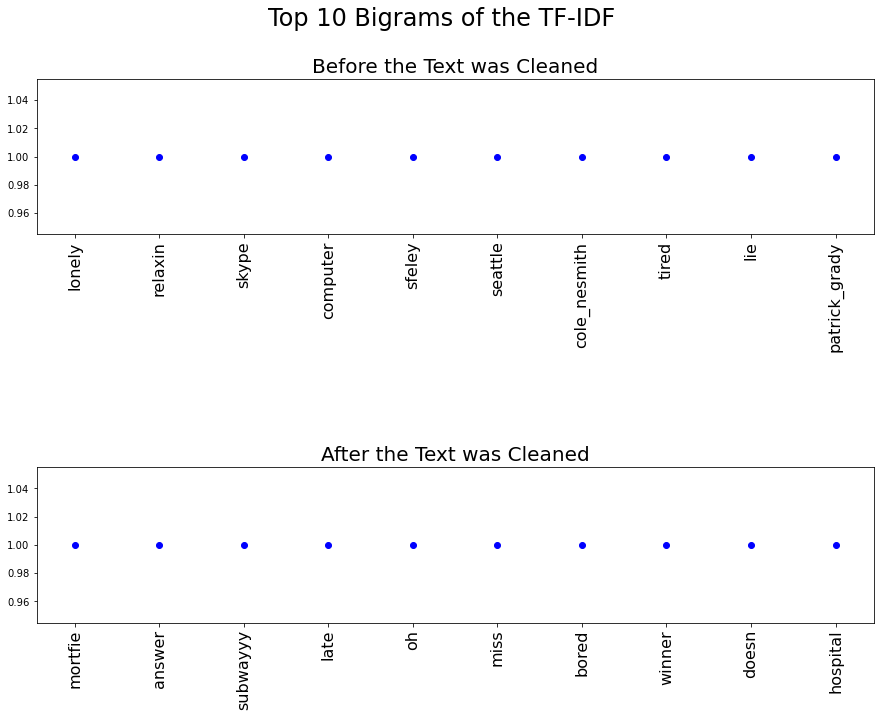

In [23]:
x=range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (15, 10))

fig.suptitle('Top 10 Bigrams of the TF-IDF', fontsize= 24)

#plot x and tf_idf
ax[0].plot(x, df_text_bc.tf_idf, 'bo')
ax[0].set_title('Before the Text was Cleaned', fontsize= 20)
ax[0].set_xticks(x)
x_ticks_labels = df_text_bc.feature
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

#plot x and tf_idf
ax[1].plot(x, df_text_ac.tf_idf, 'bo')
ax[1].set_title('After the Text was Cleaned', fontsize= 20)
ax[1].set_xticks(x)
x_ticks_labels = df_text_ac.feature
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

fig.subplots_adjust(hspace=1.5)
plt.show()

### 7. Visualize the top 10 term frequency of the tokens associated with negative tweets using scattertext.

In [24]:
nlp = spacy.load('en_core_web_sm')

#corpus clean text
corpus_bc = st.CorpusFromPandas(tweets, 
                              category_col='polarity', 
                              text_col='text',
                              nlp=nlp).build()

#corpus for clean text
corpus_ac = st.CorpusFromPandas(tweets, 
                              category_col='polarity', 
                              text_col='text_cleaned',
                              nlp=nlp).build()

In [25]:
#create the term frequency
term_freq_df_bc = corpus_bc.get_term_freq_df()

#create the negative score for the sentiment of negative
term_freq_df_bc['negative Score'] = corpus_bc.get_scaled_f_scores('negative')

#rank by descending order
term_freq_df_bc_freq = term_freq_df_bc.sort_values(by= 'negative freq', ascending=False)
term_freq_df_bc_Score = term_freq_df_bc.sort_values(by= 'negative Score', ascending=False)

#create the term frequency
term_freq_df_ac = corpus_ac.get_term_freq_df()

#create the negative score for the sentiment of negative
term_freq_df_ac['negative Score'] = corpus_ac.get_scaled_f_scores('negative')

#rank by descending order
term_freq_df_ac_freq = term_freq_df_ac.sort_values(by= 'negative freq', ascending=False)
term_freq_df_ac_Score = term_freq_df_ac.sort_values(by= 'negative Score', ascending=False)

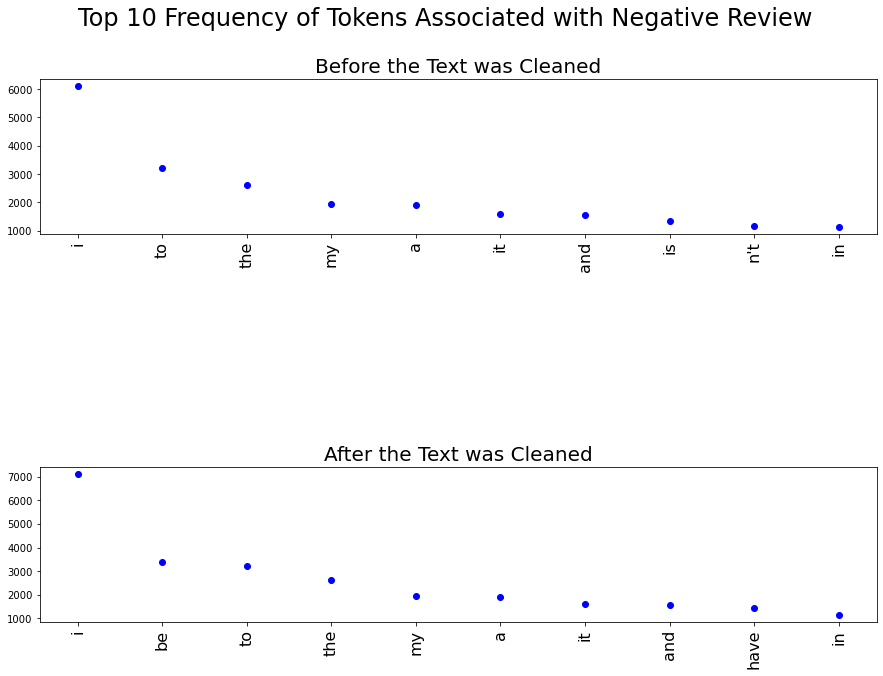

In [26]:
top_n = 10
term_freq_df_ac_freq = term_freq_df_ac_freq.head(10)
term_freq_df_bc_freq = term_freq_df_bc_freq.head(10)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (15, 10))

fig.suptitle('Top 10 Frequency of Tokens Associated with Negative Review', fontsize= 24)

#plot x and tf
ax[0].plot(x, term_freq_df_bc_freq['negative freq'], 'bo')
ax[0].set_title('Before the Text was Cleaned', fontsize= 20)

#set ticks for x-axis
ax[0].set_xticks(x)
x_ticks_labels = term_freq_df_bc_freq.index
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

#plot x and tf
ax[1].plot(x, term_freq_df_ac_freq['negative freq'], 'bo')
ax[1].set_title('After the Text was Cleaned', fontsize= 20)

#set ticks for x-axis
ax[1].set_xticks(x)
x_ticks_labels = term_freq_df_ac_freq.index
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

fig.subplots_adjust(hspace=1.5)
plt.show()

### 8. Visualize the top 10 negative scores of the tokens associated with negative tweets using scattertext.

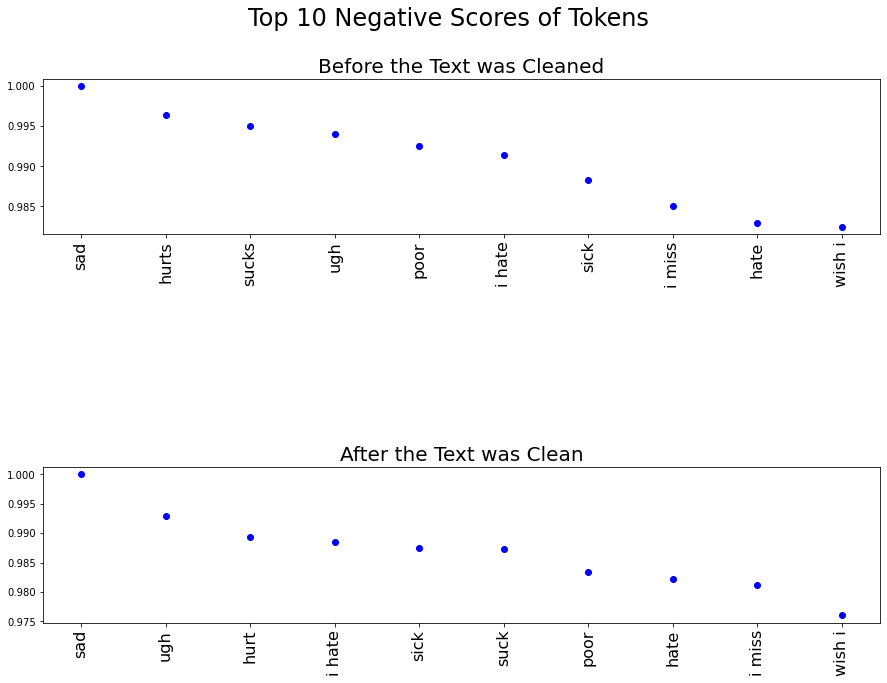

In [27]:
top_n = 10
term_freq_df_ac_Score = term_freq_df_ac_Score.head(10)
term_freq_df_bc_Score = term_freq_df_bc_Score.head(10)
x = range(0, top_n)

fig, ax = plt.subplots(2, 1, figsize = (15, 10))

fig.suptitle('Top 10 Negative Scores of Tokens', fontsize= 24)

#plot x and scores
ax[0].plot(x, term_freq_df_bc_Score['negative Score'], 'bo')
ax[0].set_title('Before the Text was Cleaned', fontsize= 20)

#set ticks for x-axis
ax[0].set_xticks(x)

#set ticks labels for x-axis
x_ticks_labels = term_freq_df_bc_Score.index
ax[0].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

#plot x and scores
ax[1].plot(x, term_freq_df_ac_Score["negative Score"], 'bo')
ax[1].set_title('After the Text was Clean', fontsize= 20)

#set number of ticks for x-axis
ax[1].set_xticks(x)

#set ticks labels for x-axis
x_ticks_labels = term_freq_df_ac_Score.index
ax[1].set_xticklabels(x_ticks_labels, rotation='vertical', fontsize=16)

fig.subplots_adjust(hspace=1.5)
plt.show()

### 9. Visualize the first five sentences embedding for each tweet using PCA.

In [28]:
#reset the df index so it will append properly
tweets.reset_index(inplace=True)

In [29]:
nlp = spacy.load("en_core_web_lg")

data_bc = []
data_ac = []

#generate the first 5 sentence/doc embeddings
top_n = 5
for idx, row in tweets.iterrows():
    if idx < top_n:
        #create the lists containing the texts, corresponding sentence/document embeddings, and sentiment
        data_ac.append([row['text_cleaned'], nlp(row['text_cleaned']).vector, row['polarity']])
        data_bc.append([row['text'], nlp(row['text']).vector, row['polarity']])
     
    else:
        break
        
#store the results in the dfs
df_ac = pd.DataFrame(data_ac, columns=['review_ac', 'vector', 'polarity'])
df_bc = pd.DataFrame(data_bc, columns=['review_bc', 'vector', 'polarity'])
pprint(df_ac)

                                           review_ac  \
0  how 2 get 1000 new follower daily 1000 daily p...   
1              be at home ready to go back to school   
2      thank god somebody else do that cursor thingy   
3  have just have an amazing day night thanks eve...   
4                      no i couldn t find a date lol   

                                              vector  polarity  
0  [-0.15826592, 0.2520756, -0.17620061, 0.009237...  positive  
1  [0.13731477, 0.18883644, -0.19692987, 0.115180...  negative  
2  [-0.012850495, -0.040778875, -0.267391, -0.159...  positive  
3  [-0.052072003, 0.26136222, -0.12525311, -0.011...  positive  
4  [-0.0379525, 0.16026875, -0.38492015, -0.11075...  negative  


In [30]:
#convert df to a n-dimensional array
X_bc = np.array(list(df_bc["vector"]))
X_ac = np.array(list(df_ac["vector"]))

#extract 2 principal componets using PCA
pca = PCA(n_components=2)
pca_bc_2d = pca.fit_transform(X_bc)
pca_ac_2d = pca.fit_transform(X_ac)

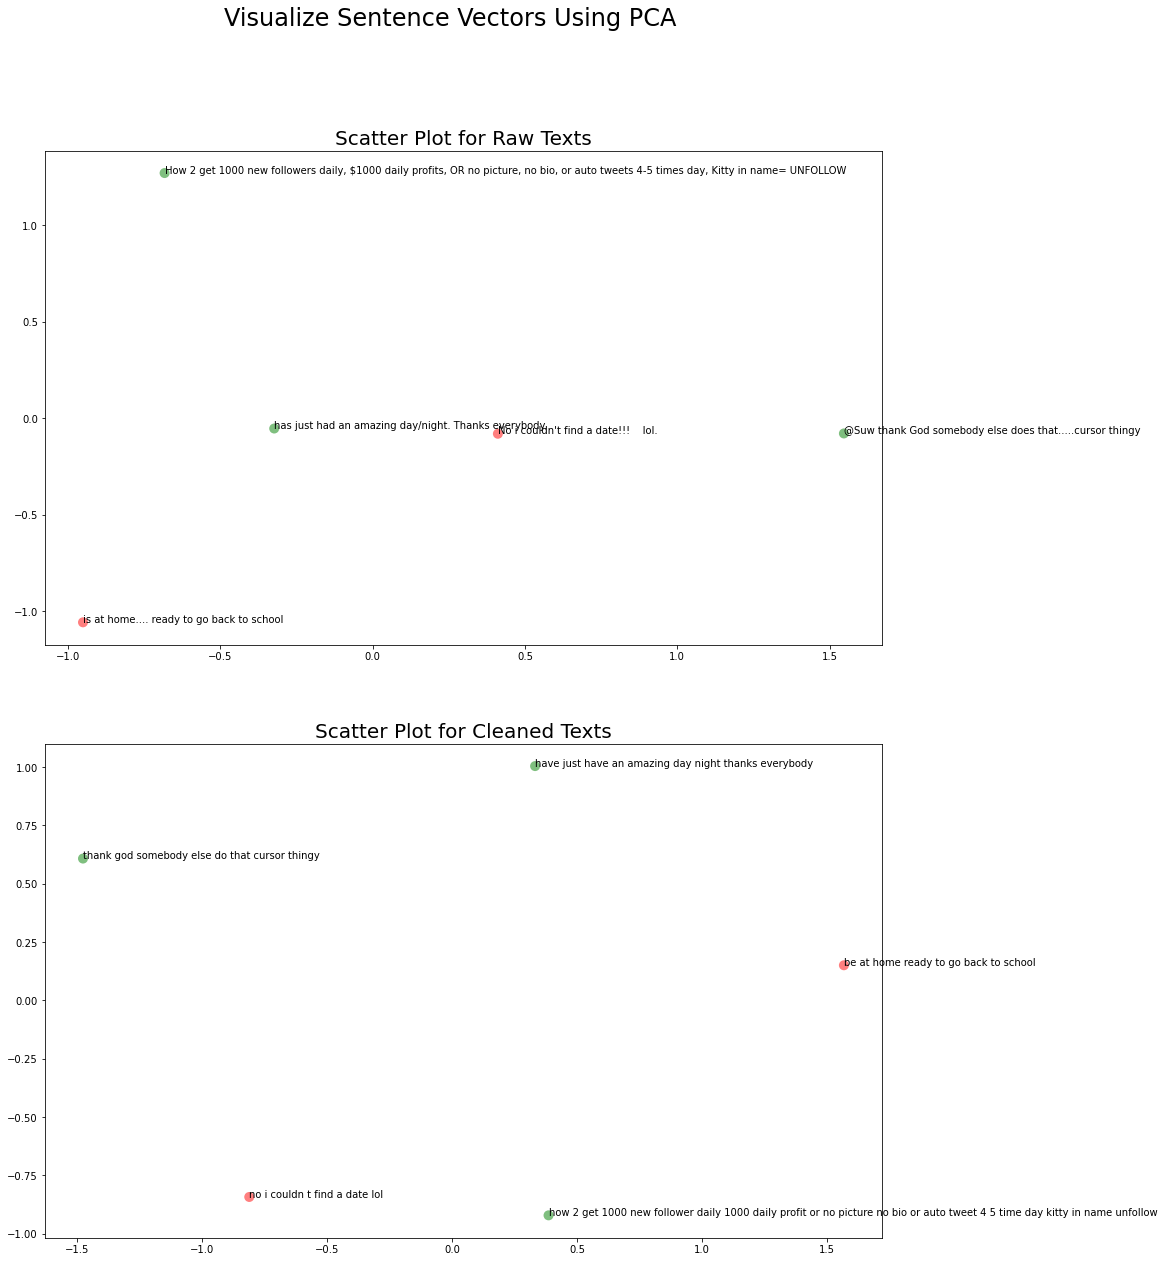

In [31]:
#plot the  PCA
review_ac = df_ac.review_ac
review_bc = df_bc.review_bc

fig, ax = plt.subplots(2, 1, figsize = (15, 10*2))
fig.suptitle('Visualize Sentence Vectors Using PCA', fontsize= 24)

colors = {'positive':'green', 'negative':'red'}

ax[0].scatter(pca_bc_2d[:,0],pca_bc_2d[:,1], s = 100,  c= df_bc['polarity'].map(colors), 
            cmap='coolwarm', edgecolor='None', alpha=0.5)
ax[0].set_title('Scatter Plot for Raw Texts', fontsize= 20)

#label the points
for idx, txt in enumerate(review_bc):
    ax[0].annotate(txt, (pca_bc_2d[idx, 0],pca_bc_2d[idx, 1]))

ax[1].scatter(pca_ac_2d[:,0],pca_ac_2d[:,1], s = 100,  c = df_ac['polarity'].map(colors), 
            cmap='coolwarm', edgecolor='None', alpha=0.5)

#label the points
for idx, txt in enumerate(review_ac):
    ax[1].annotate(txt, (pca_ac_2d[idx, 0],pca_ac_2d[idx, 1]))
ax[1].set_title('Scatter Plot for Cleaned Texts', fontsize= 20)

plt.show()

### 10. Visualize the first five sentences embedding for each tweet using t-SNE.

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.001s...
[t-SNE] Computed neighbors for 5 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 34.306641
[t-SNE] KL divergence after 600 iterations: 0.110456
[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.000s...
[t-SNE] Computed neighbors for 5 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 36.903606
[t-SNE] KL divergence after 550 iterations: 0.110456


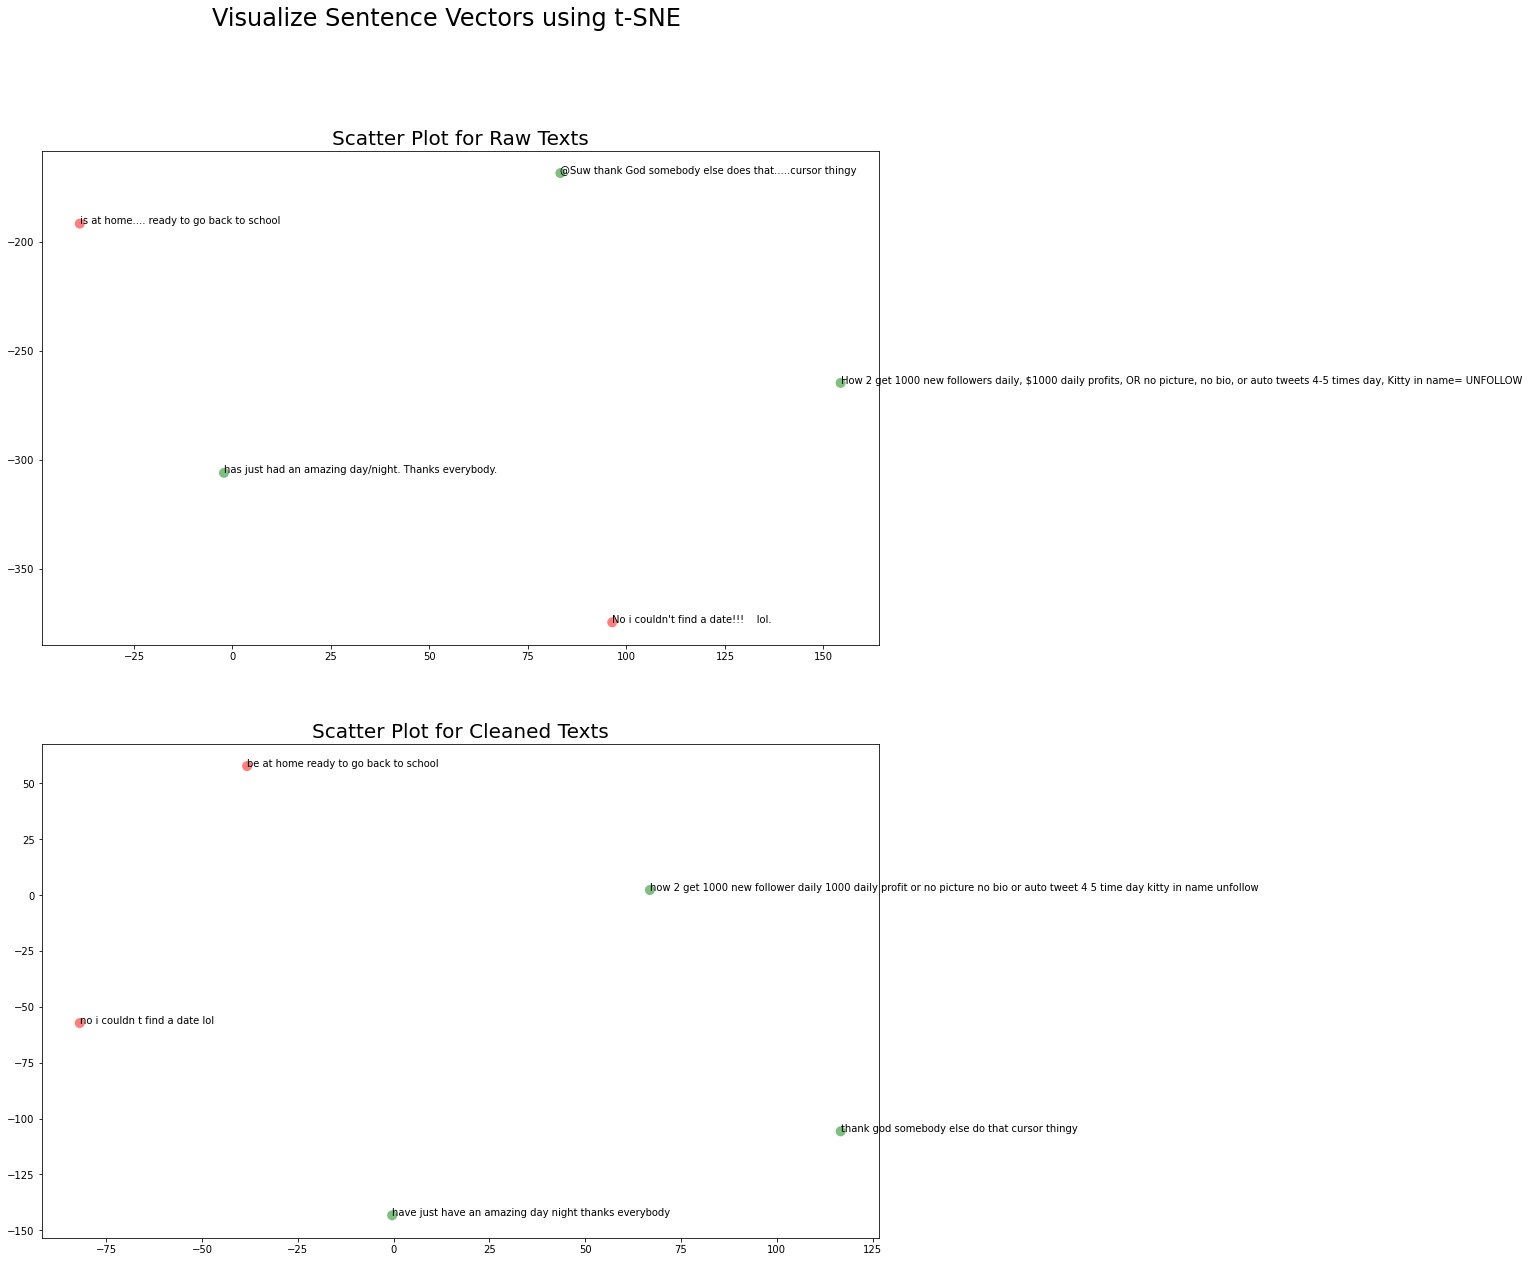

In [32]:
#extract 2 componets using t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=4000)
tsne_ac = tsne.fit_transform(X_ac)
tsne_bc = tsne.fit_transform(X_bc)

#plot the 2 component side-by-side
review_ac = df_ac.review_ac
review_bc = df_bc.review_bc

fig, ax = plt.subplots(2, 1, figsize = (15, 10*2))
fig.suptitle('Visualize Sentence Vectors using t-SNE', fontsize= 24)
colors = {'positive':'green', 'negative':'red'}

ax[0].scatter(tsne_bc[:,0],tsne_bc[:,1], s = 100,  c= df_bc['polarity'].map(colors), 
            cmap='coolwarm', edgecolor='None', alpha=0.5)
ax[0].set_title('Scatter Plot for Raw Texts', fontsize= 20)

#label the points
for idx, txt in enumerate(review_bc):
    ax[0].annotate(txt, (tsne_bc[idx, 0],tsne_bc[idx, 1]))

ax[1].scatter(tsne_ac[:,0],tsne_ac[:,1], s = 100,  c= df_ac['polarity'].map(colors),
            cmap='coolwarm', edgecolor='None', alpha=0.5)

#label the points
for idx, txt in enumerate(review_ac):
    ax[1].annotate(txt, (tsne_ac[idx, 0],tsne_ac[idx, 1]))
ax[1].set_title('Scatter Plot for Cleaned Texts', fontsize= 20)

plt.show()